<span style="font-size:30pt;font-weight:bold">General Model Workflow 0.8.3</font>

**Copyright:**

© 2017-2020, Pavel Sůva, Marek Teller, Martin Kotek, Jan Zeller, Marek Mukenšnabl, Kirill Odintsov, Jan Hynek, Elena Kuchina and Home Credit & Finance Bank Limited Liability Company, Moscow, Russia – all rights reserved

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the [License](http://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

For list of contributors see [Gitlab page](https://git.homecredit.net/risk/python-scoring-workflow) 

# Import packages, configure environment

For this workflow to work, you need to install some non-standard python packages that are not in standard Anaconda distribution - mainly widgets for GUI of some parts of this workflow:

`conda install ipywidgets`

`jupyter nbextension enable --py --sys-prefix widgetsnbextension`

`conda config --add channels conda-forge`

`conda install qgrid` 

`jupyter nbextension enable --py --sys-prefix qgrid`

`conda install tqdm`

In [1]:
import time
import datetime
import math
import random
import numpy as np
import pandas as pd
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import pickle
import gc
from tqdm import tqdm_notebook as tqdm
import sys
import warnings

sys.path.insert(0, '..')
import scoring

from scipy.special import logit, expit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [2]:
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True
from IPython.display import display, Markdown
pd.options.display.max_columns = None
pd.options.display.max_rows = 15

# create the documentation folders 
output_folder = 'documentation'
subfolders = [
    "performance",
    "predictors",
    "stability",
    "stability_grouping",
    "stability_short",
    "analysis", 
    "model",
    "nan_share"
]

os.makedirs(output_folder, exist_ok=True)
    
for folder in subfolders:
    os.makedirs(os.path.join(output_folder, folder), exist_ok=True)

psw_version = '0.9.0'
scoring.check_version(psw_version)

In [3]:
# import importlib
# importlib.reload(scoring.doctools.calculators)
# importlib.reload(scoring.doctools)
# importlib.reload(scoring)
# import scoring

In [4]:
from scoring import doctools

documentation = doctools.ProjectParameters()

# Input data

## Import data

Importing data from a CSV file. It is important to set the following parameters:

encoding: usually 'utf-8' or windows-xxxx on Windows machines, where xxxx is 1250 for Central Europe, 1251 for Cyrilic etc.
sep: separator of columns in the file
decimal: decimal dot or coma
index_col: which columns is used as index - should be the unique credit case identifier

**Defining NA values:** In different datasets, there can be different values to be considered *N/A*. By default, we set only blank fields to be considered *N/A*, however you might want to change it and add values like *'NA'*, *'NAN'*, *'null'* to be also considered *N/A*. User parameter `na_values` for this.

The data need to have **index column which has unique value per each row**. If not, it will cause problems later.

In [5]:
from scoring import db
data = db.read_csv('demo_data/gmdata.csv', sep = ',', decimal = '.',
                   optimize_types=True, encoding = 'utf-8', low_memory = False,
                   keep_default_na = False, na_values = [''])
print('Data loaded on',datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S'))

Data loaded on 2021-05-12 11:50:19


In [6]:
print('Number of rows:',data.shape[0])
print('Number of columns:',data.shape[1])

Number of rows: 19976
Number of columns: 12


In [7]:
data.head()

,ID,DATETIME,INTERNAL,TELCO_A,TELCO_B,BUREAU_X,BUREAU_Y,BUREAU_Y_STATUS,UTILITY,DEVICE,APPROVED,FPD30
0,100001,2017-01-01 00:16:26,5.206850,NaN,60.0,-2.0,NaN,NO-ASK,GOOD,NaN,1.0,0.0
1,100002,2017-01-01 00:21:21,3.128133,0.065593,NaN,NaN,NaN,NO-ASK,DEBTOR,NaN,1.0,0.0
2,100003,2017-01-01 00:28:48,3.407969,NaN,60.0,301.0,0.912895,HIT,DEBTOR,NaN,1.0,1.0
3,100004,2017-01-01 00:37:40,3.003826,0.114979,NaN,298.0,0.895788,HIT,N/A,NaN,0.0,NaN
4,100005,2017-01-01 00:41:02,3.151118,NaN,62.0,NaN,0.940414,HIT,ERROR,NaN,1.0,0.0


## Metadata definition

Assigning target column, time column and ID column (observation identifier) which have to exist within the dataset.

All the rest (i.e. base which tells where the target is observable, month and day which are derived from the time, and weight which gives weight - importance - to each row individually) are created automatically later if they don't exist at this moment.

In [8]:
### THESE COLUMNS MUST BE INCLUDED IN THE DATA SET ###
#name of the target column
col_target = "FPD30"
#name of the time column
col_time = "DATETIME"
#name of ID column
col_id = "ID"

### THESE COLUMNS DON'T HAVE TO BE INCLUDED IN THE DATA SET AND ARE CREATED AUTOMATICALLY LATER ###
#name of the base column
col_base = "APPROVED"
#name of the month column
col_month = "MONTH"
#name of the day column
col_day = "DAY"
#name of the weight column 
col_weight = 'WEIGHT'

In [9]:
documentation.targets = [(col_target, col_base)]
documentation.time_variable = col_month
documentation.weight = col_weight

In [10]:
documentation.rowid_variable = col_id

In [11]:
pd.DataFrame.from_records([['col_time',col_time],['col_month',col_month],['col_day',col_day],['col_target',col_target],['col_base',col_base]]) \
.to_csv(output_folder+'/model/metadata.csv',index=0,header=None)

data[col_target] = data[col_target].astype(np.float)

If you don't have base column in your data set, the following code adds it (based on if target is filled).

In [12]:
if col_base not in data:
    data[col_base] = 0
    data.loc[data[col_target]==0,col_base] = 1
    data.loc[data[col_target]==1,col_base] = 1
    print('Column',col_base,'added/modified. Number of columns:',data.shape[1])
else:
    print('Column',col_base,'already exists.')

Column APPROVED already exists.


If you don't have weight column in your data set, the following code adds it, with value = 1 for each row.

In [13]:
if col_weight not in data:
    data[col_weight] = 1
    print('Column',col_weight,'added/modified. Number of columns:',data.shape[1])
else:
    print('Column',col_weight,'already exists.')

Column WEIGHT added/modified. Number of columns: 13


Create the month and day column from the time column is doing the following
- take the time column and tell in which format the time is saved in - **you need to specify this in variable *dtime_input_format*** (see https://docs.python.org/3/library/time.html#time.strftime for reference)
- strip the format just to year, month, day string
- convert the string to number
- the new column will be added to the dataset as day
- truncate this column to just year and month and add it to dataset as month

In [14]:
dtime_input_format = '%Y-%m-%d %H:%M:%S'

In [15]:
data[col_day] = pd.to_numeric(pd.to_datetime(data[col_time], format=dtime_input_format).dt.strftime('%Y%m%d'))
data[col_month] = data[col_day].apply(lambda x: math.trunc(x/100))
print('Columns',col_day,'and',col_month,'added/modified. Number of columns:',data.shape[1])

Columns DAY and MONTH added/modified. Number of columns: 15


In [16]:
data.head(5)

,ID,DATETIME,INTERNAL,TELCO_A,TELCO_B,BUREAU_X,BUREAU_Y,BUREAU_Y_STATUS,UTILITY,DEVICE,APPROVED,FPD30,WEIGHT,DAY,MONTH
0,100001,2017-01-01 00:16:26,5.206850,NaN,60.0,-2.0,NaN,NO-ASK,GOOD,NaN,1.0,0.0,1,20170101,201701
1,100002,2017-01-01 00:21:21,3.128133,0.065593,NaN,NaN,NaN,NO-ASK,DEBTOR,NaN,1.0,0.0,1,20170101,201701
2,100003,2017-01-01 00:28:48,3.407969,NaN,60.0,301.0,0.912895,HIT,DEBTOR,NaN,1.0,1.0,1,20170101,201701
3,100004,2017-01-01 00:37:40,3.003826,0.114979,NaN,298.0,0.895788,HIT,N/A,NaN,0.0,NaN,1,20170101,201701
4,100005,2017-01-01 00:41:02,3.151118,NaN,62.0,NaN,0.940414,HIT,ERROR,NaN,1.0,0.0,1,20170101,201701


Set of predictor (subscores) to be analyzed. These are the potential elements of the final General Model score.

In [17]:
cols_pred = [
    'INTERNAL',
    'TELCO_A',
    'TELCO_B',
    'BUREAU_X',
    'BUREAU_Y',
    'UTILITY',
    'DEVICE',
]

## Data exploration

In [18]:
descrip = data.describe(include='all').transpose()
pd.options.display.max_rows = 1000
display(descrip)
pd.options.display.max_rows = 15

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,19976,NaN,NaN,NaN,112722,9826.92,100001,104995,109988,125902,130896
DATETIME,19976,19960,2017-06-06 20:18:38,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
INTERNAL,19976,NaN,NaN,NaN,2.50194,1.00587,-1.41988,1.81886,2.503,3.17725,7.15196
TELCO_A,5484,NaN,NaN,NaN,0.0831296,0.0380225,0.0143291,0.0554773,0.0761857,0.102664,0.349384
TELCO_B,7966,NaN,NaN,NaN,62.0254,2.52587,52,60,62,64,71
BUREAU_X,8340,NaN,NaN,NaN,165.001,154.232,-2,-2,293,308,338
BUREAU_Y,5887,NaN,NaN,NaN,0.915938,0.0390964,0.625791,0.895876,0.923401,0.944401,0.984886
BUREAU_Y_STATUS,19976,3,NO-ASK,12611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UTILITY,14976,5,N/A,5595,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEVICE,5000,NaN,NaN,NaN,0.917344,0.0388667,0.674121,0.897919,0.924751,0.945081,0.986543


**Default rate in time**: Simple visualisation of observation count and default rate in time

In [19]:
observable_mask = data[col_base] == 1

documentation.sample_dict = {
    "Observable": observable_mask}

In [20]:
documentation.PlotDataset(
    data,
    sample="Observable",
    target=col_target,
    segment_col=None,
    output_folder=os.path.join(output_folder, "analysis"),
    use_weight=True,
)

**NaN share by month** for each variable in dataset:

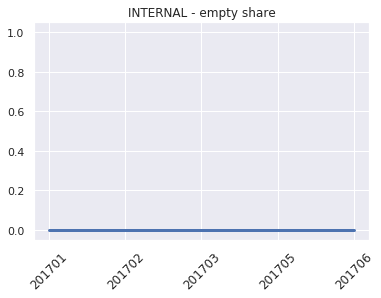

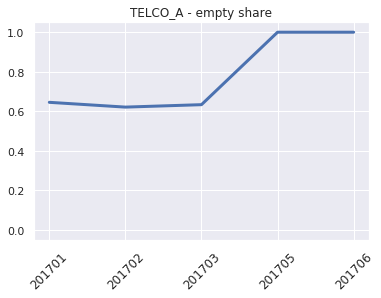

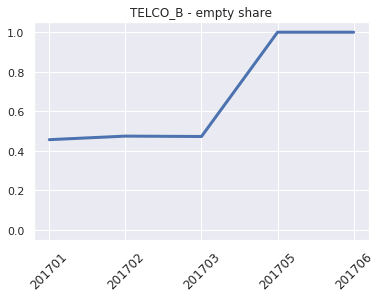

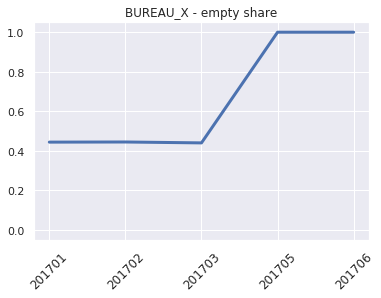

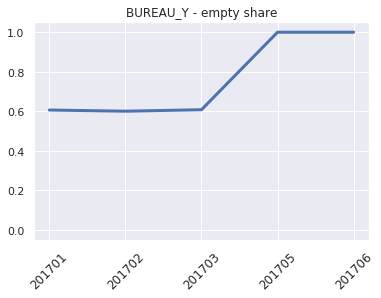

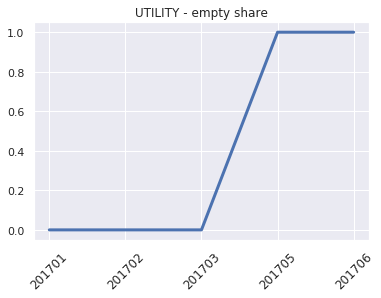

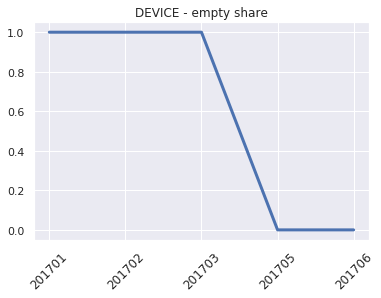

MONTH,201701,201702,201703,201705,201706
predictor,,,,,
BUREAU_X,0.443884,0.444574,0.440021,1.0,1.0
BUREAU_Y,0.606262,0.600350,0.607808,1.0,1.0
DEVICE,1.000000,1.000000,1.000000,0.0,0.0
INTERNAL,0.000000,0.000000,0.000000,0.0,0.0
TELCO_A,0.645264,0.621062,0.633402,1.0,1.0
TELCO_B,0.456354,0.474329,0.472337,1.0,1.0
UTILITY,0.000000,0.000000,0.000000,1.0,1.0


In [21]:
documentation.EmptyInTime(data,
                          sample="Observable",
                          predictors=cols_pred,
                          empty_representations=[np.nan],
                          use_weight=False,
                          show_plot=True,
                          output_folder=output_folder + "/nan_share/",
                         )

## Mask definitions

### Split to samples

Split data into five parts (training and validation). GM model is usually trained on small and time-limited sample, so test and out of time samples are usually not created.

This will add a new column indicating to which part the observations belong.

- The *splitting_points* (first date of train and first date of out of time sample) can be adjusted (there can be any number of such splitting points) - it should correspond to values of column specified by *time_column* parameter. If empty list is used, no time splits will be done.
- For each time interval, you can create multiple random splits (i.e. train/valid/test), the ratio of sizes of these splits is set by parameter *sample_sizes*. In our case we have just one time interval, so only one list of sample sizes.
- The random splits can be stratified by multiple variables, which are specified in a list - argument to *stratify_by_columns* parameter
- Set the random seed so the results are replicable

**Before you run data split, make sure that index in your dataset in unique!** If not, you need to create new unique index.

In [22]:
# data['INDEX_ORIGINAL'] = data.index
# data.reset_index(inplace=True)

In [23]:
from scoring.data_manipulation import data_sample_time_split

col_datatype = 'data_type'

data[col_datatype] = data_sample_time_split(data, 
                           time_column = col_month,
                           splitting_points = [],
                           sample_sizes = [[ 0.5   , 0.5   ]],
                           sample_names = [['train','valid']],
                           stratify_by_columns = [col_month,col_target],
                           random_seed = 1234)

train   9,988 rows
valid   9,988 rows


Masks: boolean vectors corresponding to rows in the datasets. True if an row is observable and its data type belongs to given sample.

`observable_mask` is mask where all observable rows are included (i.e. valid observations from all the samples)

`everything_mask` is mask which is True for all rows.

In [24]:
train_mask = (data[col_datatype] == 'train') & (data[col_base] == 1) 
valid_mask = (data[col_datatype] == 'valid') & (data[col_base] == 1) 
observable_mask = data[col_base] == 1
everything_mask = pd.notnull(data[col_datatype])

Add masks to _documentation_ object.

In [25]:
documentation.sample_dict = {
    "Train": train_mask,
    "Valid": valid_mask,
    "Observable": observable_mask,
    "Everything": everything_mask,
}

Data summary (number of defaults, number in base, number of observations, default rate) by month and by sample

In [26]:
data_summary = data.groupby([col_month,col_datatype]).aggregate({
    col_target:'sum',col_base:['sum','count']
})
data_summary.columns = [col_target,col_base,'Rows']
data_summary[col_target+' rate'] = data_summary[col_target]/data_summary[col_base]
display(data_summary)

data_summary = data_summary.reset_index(level=col_datatype).pivot(columns=col_datatype)
display(data_summary)
data_summary.to_csv(output_folder+'/analysis/summary.csv')

FPD30  APPROVED  Rows  FPD30 rate
MONTH  data_type                                   
201701 train      169.0    1884.0  2569    0.089703
       valid      169.0    1885.0  2571    0.089655
201702 train      150.0    1714.0  2321    0.087515
       valid      150.0    1714.0  2321    0.087515
201703 train      187.0    1935.0  2598    0.096641
       valid      186.0    1933.0  2596    0.096223
201705 train        0.0       2.0     4    0.000000
       valid        0.0       2.0     3    0.000000
201706 train      182.0    1845.0  2496    0.098645
       valid      182.0    1846.0  2497    0.098592

FPD30        APPROVED          Rows       FPD30 rate          
data_type  train  valid    train   valid train valid      train     valid
MONTH                                                                    
201701     169.0  169.0   1884.0  1885.0  2569  2571   0.089703  0.089655
201702     150.0  150.0   1714.0  1714.0  2321  2321   0.087515  0.087515
201703     187.0  186.0   1935.0  1933.0  2598  2596   0.096641  0.096223
201705       0.0    0.0      2.0     2.0     4     3   0.000000  0.000000
201706     182.0  182.0   1845.0  1846.0  2496  2497   0.098645  0.098592

# Reweighting

This part serves to set weights based on hit rates of each score (data source).

If we have only limited number of observations for each score, but in production, we expect different hit rates, we can assign weights to each observation to give it such importance that it reflects the expected hit rates.

E.g. if we have only 25% of hits in the development population for certain data source, but we expect it to be 50% in production, we assign weight=3 to this hit population, so now the non-hit population and hit population have the same sum of weights.

## Hit rates

Calculates hit rates for each data source in our development data

In [27]:
hit_flags = data[[col_weight, col_month]].copy()
for col in cols_pred:
    hit_flags[col] = data[col].notnull()

### Hits by score

In [28]:
hit_rates = []
for col in cols_pred:
    hit_rates.append({'Variable': col,
                     'Weighted hit rate %': hit_flags[observable_mask & hit_flags[col]][col_weight].sum()*100 /
                                      hit_flags[observable_mask][col_weight].sum(),
                     })
hit_rates = pd.DataFrame(hit_rates).set_index('Variable')
display(hit_rates)
hit_rates.to_csv(output_folder+'/predictors/hit_rates_unweighted.csv')

,Weighted hit rate %
Variable,
INTERNAL,100.000000
TELCO_A,27.466125
TELCO_B,39.918699
BUREAU_X,41.775068
BUREAU_Y,29.613821
UTILITY,74.966125
DEVICE,25.033875


### Hits by score in time

In [29]:
hit_rates_time = []
for col in cols_pred:
    for month in hit_flags[col_month].unique():
        hit_rates_time.append({'Variable': col,
                               'Month': month,
                               'Weighted hit rate %': hit_flags[observable_mask & hit_flags[col] & (hit_flags[col_month]==month)][col_weight].sum()*100 /
                                                hit_flags[observable_mask & (hit_flags[col_month]==month)][col_weight].sum(),
                              })
hit_rates_time = pd.DataFrame(hit_rates_time).pivot(index='Variable', columns='Month', values='Weighted hit rate %').reindex(cols_pred)
display(hit_rates_time)
hit_rates_time.to_csv(output_folder+'/predictors/hit_rate_time.csv')

Month,201701,201702,201703,201705,201706
Variable,,,,,
INTERNAL,100.000000,100.000000,100.000000,100.0,100.0
TELCO_A,35.473600,37.893816,36.659772,0.0,0.0
TELCO_B,54.364553,52.567095,52.766287,0.0,0.0
BUREAU_X,55.611568,55.542590,55.997932,0.0,0.0
BUREAU_Y,39.373839,39.964994,39.219235,0.0,0.0
UTILITY,100.000000,100.000000,100.000000,0.0,0.0
DEVICE,0.000000,0.000000,0.000000,100.0,100.0


### Combined hits

Caluclate hit rate interactions, i.e. what are the shares of various data source hits.

In [30]:
hit_rates_comb = pd.DataFrame(hit_flags[observable_mask].groupby(cols_pred)[col_weight].sum()*100 /
                              hit_flags[observable_mask][col_weight].sum()).rename(columns={col_weight:'Weighted obs %'})
display(hit_rates_comb)
hit_rates_comb.to_csv(output_folder+'/predictors/hit_rate_interactions.csv')

Weighted obs %
INTERNAL TELCO_A TELCO_B BUREAU_X BUREAU_Y UTILITY DEVICE                
True     False   False   False    False    False   True         25.033875
                                           True    False         2.093496
                                  True     True    False         1.253388
                         True     False    True    False         2.682927
                                  True     True    False         1.551491
                 True    False    False    True    False        10.365854
                                  True     True    False         7.025745
                         True     False    True    False        13.482385
                                  True     True    False         9.044715
         True    False   False    False    True    False         7.567751
                                  True     True    False         4.884824
                         True     False    True    False         9.159892
                                  True     True    False         5.853659

## Setting desired situation

Now we set what are the hit rates that we expect, i.e. what will be the situation in production.

In [31]:
hit_desired = hit_rates.copy()
hit_desired['Desired hit rate %'] = np.nan

### Setting desired hit rates in code

Either we can hardcode these numbers into the dataframe with desired hit rates...

In [32]:
hit_desired.loc['INTERNAL','Desired hit rate %'] = 100
hit_desired.loc['TELCO_A','Desired hit rate %'] = 50
hit_desired.loc['TELCO_B','Desired hit rate %'] = 50
hit_desired.loc['BUREAU_X','Desired hit rate %'] = 40
hit_desired.loc['BUREAU_Y','Desired hit rate %'] = 40
hit_desired.loc['UTILITY','Desired hit rate %'] = 65
hit_desired.loc['DEVICE','Desired hit rate %'] = 50

### Interactive tool

...or we can use interactive qgrid table to set it in nicer GUI. **Don't forget to run the piece of code under the table which saves the changed values into the dataframe.**

In [33]:
import qgrid

hit_widget = qgrid.show_grid(hit_desired, 
                             column_options={'editable':False}, 
                             column_definitions={'Desired hit rate %':{'editable':True}},
                            )
hit_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Save the changed values:

In [34]:
hit_desired = hit_widget.get_changed_df()

## Assign weights to reflect desired situation

The weights are caluclated, so the weighted hit rates (i.e. hit rates when each observation's importance is multiplied by the newly calculated weights) reflect the desired (expected production) hit rates from `hit_desired` dataframe.

**Assumptions:** Hit rates of individual scores are mutually independent and time consistent.

In [35]:
# data[col_weight] = 1

In [36]:
for var_name, hit_row in hit_desired.iterrows():
    if (hit_row['Desired hit rate %'] == 100) or (hit_row['Weighted hit rate %'] == 100):
        coef = 1
    else:
        coef = (hit_row['Desired hit rate %'] * data.loc[observable_mask & pd.isnull(data[var_name]), col_weight].sum()) /\
               ((100-hit_row['Desired hit rate %']) * data.loc[observable_mask & pd.notnull(data[var_name]), col_weight].sum())
    data.loc[pd.notnull(data[var_name]), col_weight] = \
        data.loc[pd.notnull(data[var_name]), col_weight] * coef
weight_calib_coef = data[col_weight].count() / data[col_weight].sum()
data[col_weight] = data[col_weight] * weight_calib_coef

In [37]:
hit_flags = data[[col_weight, col_month]].copy()
for col in cols_pred:
    hit_flags[col] = data[col].notnull()

hit_rates_w = []
for col in cols_pred:
    hit_rates_w.append({'Variable': col,
                     'Weighted hit rate %': hit_flags[observable_mask & hit_flags[col]][col_weight].sum()*100 /
                                      hit_flags[observable_mask][col_weight].sum(),
                     })
hit_rates_w = pd.DataFrame(hit_rates_w).set_index('Variable')
display(hit_rates_w)
hit_rates_w.to_csv(output_folder+'/predictors/hit_rates_weighted.csv')

,Weighted hit rate %
Variable,
INTERNAL,100.000000
TELCO_A,19.623555
TELCO_B,28.345226
BUREAU_X,23.255337
BUREAU_Y,22.929610
UTILITY,50.000000
DEVICE,50.000000


*In the demo data that we have here, the assumptions of independence and time consistency are not fullfiled. Variable DEVICE is observable only in a month when no other variable is observable. This means that the final weights are not able to mimick the desired hit rates*

# Datasources analysis

We will analyze each score which can potentially enter the General Model. These scores were defined in list `cols_pred` above.

## Univariate power of raw scores

For each score, we calculate its Gini on such subset, where the target is observable and that particular score is not null. We then see what is the power of the score when we have it (i.e. on its *"hit" population*, where hit means that the datasource which returns the score was queried and valid score was returned)

In [38]:
from scoring.metrics import gini

uni_ginis = []
for col in cols_pred:
    if pd.api.types.is_numeric_dtype(data[col].dtype):
        col_gini = np.abs(gini(data[pd.notnull(data[col]) & observable_mask][col_target],
                               data[pd.notnull(data[col]) & observable_mask][col],
                               data[pd.notnull(data[col]) & observable_mask][col_weight]))
        uni_ginis.append({'Variable':col,
                          'Gini': col_gini,
                        })
uni_ginis = pd.DataFrame(uni_ginis)[['Variable','Gini']]
display(uni_ginis)
uni_ginis.to_csv(output_folder+'/predictors/univariate_gini.csv')

,Variable,Gini
0,INTERNAL,0.352798
1,TELCO_A,0.119879
2,TELCO_B,0.182054
3,BUREAU_X,0.066478
4,BUREAU_Y,0.161644
5,DEVICE,0.194205


## Score transformation

Each datasource can return score in a different format. 
- Sometimes it is probability of default or non-default (and these can have various definitions for each source).
- Sometimes it is logit, i.e. real number which after expit transformation becomes the probability.
- Sometimes it is logit, but linearly transformed to fit into a specific scale.
- Sometimes the logic is not known but the score is somehow correlated with defaults.
- Sometimes there are specific "special values" which are out of standard score scale and which are telling us that something non-standard occured (e.g. error codes).

### Inverted logit to logit

`logit(Probability of default) = -logit(Probability of non-default)`

In [39]:
for col in [
    'INTERNAL'
]:
    data[col+'_LIN'] = -data[col]

### Logit from PD

In [40]:
for col in [
    'TELCO_A',
]:
    data[col+'_LIN'] = logit(data[col])

### Logit from inverted PD

In [41]:
for col in [
    'BUREAU_Y',
    'DEVICE',
]:
    data[col+'_LIN'] = logit(1-data[col])

### Logit by linear scaling

when the score is logit of PD, but linearly shifted, we run logistic regression with just this score as sole predictor to calculate proper intercept and slope to shift it back to calibrate it to our default

In [42]:
for col in [
    'TELCO_B',
]:
    telco_b_scaler = LogisticRegression(penalty = 'l2', C = 1000, solver='liblinear')
    telco_b_scaler.fit(data[(data[col].notnull()) & observable_mask][[col]],
                       data[(data[col].notnull()) & observable_mask][col_target])
    print(f'Intercept: {telco_b_scaler.intercept_[0]}, Slope: {telco_b_scaler.coef_[0][0]}')
    data[col+'_LIN'] = telco_b_scaler.intercept_[0] + telco_b_scaler.coef_[0][0] * data[col]

Intercept: 5.770106157572125, Slope: -0.13059660273979767


### WOE for unknown scale and categorical

If the score has unknown scale or is categorical, we can calculate Weight of Evidence as with common predictors. We will use the Interactive grouping for this.

A new instance of **InteractiveGrouping** class is created. There are two important parameters:
 - *colums*: list of numerical columns to be grouped
 - *cat_columns*: list of categorical columns to be grouped
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

Then you open the interactive environment using **display** method. The important parameters are:
 - *train_t*: training dataset the grouping should be based on
 - *colums*: list of numerical columns to be grouped and displayed
 - *cat_columns*: list of categorical columns to be grouped and displayed
 - *target_column*: as the grouping is supervised and calculates WOE values, you need to specify the target column name
 - *w_column*: vector of weights of obervation (if not filled, grouping behaves as there are equal weights)
 - *filename*: use only if you want to load a grouping that you created and saved previously
 - *group_count*: (maximal) number of final groups of each variable
 - *min_samples*: minimal number of observations in each group of each numerical variable
 - *min_samples_cat*: minimal number of observations in each group of each categorical variable

In the interactive environment, you can see four sections. From top to bottom:
- **Chart section**: 
 - For **numerical variables**, there is chart with equifrequncy fine classing (observations as bars, default rate as line), equidistant fine classing and the final groups.
 - For **categorical varibles** there is chart with each of the original categorical values and a chart with the final groups.
- **Variable section**: here you can choose tab with varible which you want to edit. 
 - For **numerical variables**, the tab contains of the borders of the final groups. You can edit these borders, add new with [+] button and remove them with [-] button. You can also manually set WOE for nulls. There is also a button to perform automatic grouping on the selected variable.
 - For **categorical variables**, the tab contains of two tables. In the top table, you can see some statistics for each of the categorical values. In the rightmost column, there is the number of group which is assigned to the category. You can edit this value (doubleclick on it) to change the grouping. In the bottom table you can see statistics for the groups. It is not editable. There is also a button to perform automatic grouping on the selected variable.
- **Save section**: here you can save the grouping. Edit the file name and click the [Apply and Save] button.
- **Settings section**: If you perform automatic grouping on some varible, the grouping algorithm uses some parameters. These parameters can be set here. You can set how many final groups do you want to have and what is their minimal size.

/opt/anaconda2/envs/py36/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/opt/anaconda2/envs/py36/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda2/envs/py36/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/opt/anaconda2/envs/py36/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/opt/anaconda2/envs/py36/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecatio

<IPython.core.display.Javascript object>


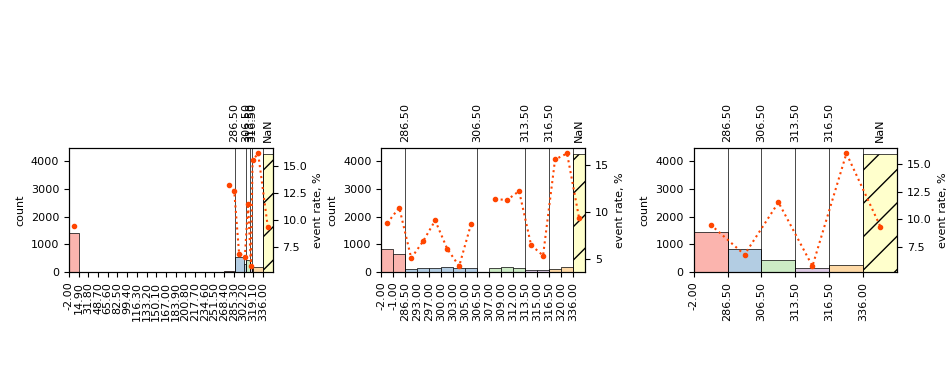

In [45]:
from scoring.grouping import Grouping, InteractiveGrouping

cols_togroup_num = [
                       'BUREAU_X',
]
cols_togroup_cat = [
                       'UTILITY',
]

grouping = InteractiveGrouping(columns = cols_togroup_num,
                               cat_columns = cols_togroup_cat,
                               group_count=5,
                               min_samples=100, 
                               min_samples_cat=100,
                               woe_smooth_coef=0.001)

sns.reset_orig()
%matplotlib notebook
%config InlineBackend.close_figures=False

grouping.display(#train_t = data[train_mask][cols_togroup_num+cols_togroup_cat+[col_target]],
                 train_t = data[train_mask][cols_togroup_num+cols_togroup_cat+[col_target]+[col_weight]], #for call with weight
                 columns = cols_togroup_num,
                 cat_columns = cols_togroup_cat,
                 target_column = col_target,
                 w_column = col_weight,
                 #filename = 'myIntGrouping',
                 bin_count=20,
                 woe_smooth_coef=0.001,
                 group_count=5,
                 min_samples=100,
                 min_samples_cat=100)

In [47]:
qgrid.__version__

'1.3.1'

Don't forget to *Apply and Save* your changes.

In [ ]:
#reset the graphical environment to be used by the normal non-interactive charts
sns.set()
%matplotlib inline
%config InlineBackend.close_figures=True

Load the grouping from a file (don't forget to set the right filename) and add the WOE columns to the original dataset.

In [ ]:
# from scoring.grouping import Grouping
# grouping = Grouping(columns = cols_togroup_num,
#                     cat_columns = cols_togroup_cat,
#                     group_count=5, 
#                     min_samples=100, 
#                     min_samples_cat=100,
#                     woe_smooth_coef=0.001) 
# g_filename = 'myIntGrouping'
# grouping.load(g_filename)

Apply the grouping to the data. *Grouping.transform()* method now automatically renames columns with proper suffix. If you need to transform just subset of columns use parameter *columns_to_transform=\[...\]*.

In [ ]:
data_woe = grouping.transform(data, transform_to='woe', progress_bar=True)

Add WOE variabes to the data set.

In [ ]:
woe_columns_to_replace = list()
for column in data_woe.columns:
    if column in data:
        woe_columns_to_replace.append(column)
        print('Column', column ,'dropped as it already existed in the data set.')
data = data.drop(woe_columns_to_replace, axis='columns')
data = data.join(data_woe)

del data_woe
gc.collect()

print('Added WOE variables. Number of columns:',data.shape[1])
cols_woe = [s + '_WOE' for s in cols_pred]

## Score distribution and calibration

Once we transformed all the scores to form which is after expit transformation linearly dependent on default rate, we can draw charts of its distribution and also compare the predicted probability in each quantile with predicted default rate.

In [ ]:
from scoring.plot import score_calibration

List of *transformed* scores (i.e. each score must be in its logit form).

In [ ]:
cols_pred_transformed = [
    'INTERNAL_LIN',
    'TELCO_A_LIN',
    'TELCO_B_LIN',
    'BUREAU_X_WOE',
    'BUREAU_Y_LIN',
    'UTILITY_WOE',
    'DEVICE_LIN',
]

Each of the following charts consists of:
- red columns: histogram of score - number of observations in each quantile, tied to the left y axis
- black dashed line: predicted probability of default (i.e. `exp(x)/1+exp(x)`) of x axis
- blue line: acutal default rate in each quantile, tied to the right y axis, should correspond to the black dashed line
- green dashed line: actual default rate of observations where the score is null, tied to the right y axis

The numbers under each chart are:
- average predicted default rate (i.e. average of values of black dashed line of the whole population where the score is not null)
- average hit default rate (i.e. average of values of blue line of the whole population where the score is not null)
- average non-hit default rate (i.e. value of the green dashed line)
- hit gini (metric of quality of prediction for population where the score is not null)

In [ ]:
for col in cols_pred_transformed:
    if col[-3:] == 'WOE':
        shift, scale = np.log(data[observable_mask][col_target].sum() / (1-data[observable_mask][col_target]).sum()), -1
    else:
        shift, scale = 0, 1
    documentation.CalibrationDistribution(
        data=data,
        sample="Observable",
        target=col_target,
        score=col,
        shift=shift,
        scale=scale,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=None,
        output_folder=output_folder+'/predictors/'
    )

# Building the model step by step

In this part, we will build the model step by setp, so after transformation all variables to logit, we have to:
- impute the missing values of the subscores by valid numbers. These numbers should be based on relationship of score and default from the observations where the score is known
- fit the model using these imputed variables

## Missing value imputation

### Imputation based on missing

In case we have a certain data source available only for certain observations, we need to fill the data source's score with some placeholder values to be able to fit the regression model correctly.

This placeholder value should correspond to the average default rate of this group in such way that there is the same relationship between default rate and score as the observations where the score is known.

After each imputation, we draw a chart of the score distribution with a vertical reference line corresponding to the imputed value as a sanity check whether the makes sense to us.

#### Basic imputation assuming linear dependency of score expit and target

Calculates imputation value for score that is missing for some observations. Based on default rate in hit sample, average score in hit sample and default rate in no-hit sample, it caluclates score for no-hit sample (using simple proportion formula - "trojčlenka"). The score is taken in its logit form, then converted to probability of default and then the calculation is done (or, if parameter `ispd=True`, it is assumed that score already is in probability of default form).

$$\text{Imputation score (PD)} = \frac{ \text{Avg non-hit default rate}}{\text{Avg hit default rate}}\times\text{Avg hit score (PD)}$$

In [ ]:
from scoring.score_imputation import missing_value

In [ ]:
fill_val = missing_value(sample_hit = data[train_mask & ~np.isnan(data["TELCO_A_LIN"])],
                        sample_nohit = data[train_mask & np.isnan(data["TELCO_A_LIN"])],
                        score = "TELCO_A_LIN",
                        target = col_target,
                        weight = col_weight,
                        ispd = False)
print(f'Imputation value: {fill_val}')

data["TELCO_A_LIN_MV"] = data["TELCO_A_LIN"].copy()
data.loc[np.isnan(data["TELCO_A_LIN"]), "TELCO_A_LIN_MV"] = fill_val

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="TELCO_A_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=fill_val,
    )

In [ ]:
fill_val = missing_value(sample_hit = data[train_mask & ~np.isnan(data["TELCO_B_LIN"])],
                        sample_nohit = data[train_mask & np.isnan(data["TELCO_B_LIN"])],
                        score = "TELCO_B_LIN",
                        target = col_target,
                        ispd = False)
print(fill_val)

data["TELCO_B_LIN_MV"] = data["TELCO_B_LIN"].copy()
data.loc[np.isnan(data["TELCO_B_LIN"]), "TELCO_B_LIN_MV"] = fill_val

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="TELCO_B_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=fill_val,
    )

In [ ]:
fill_val = missing_value(sample_hit = data[train_mask & ~np.isnan(data["DEVICE_LIN"])],
                        sample_nohit = data[train_mask & np.isnan(data["DEVICE_LIN"])],
                        score = "DEVICE_LIN",
                        target = col_target,
                        weight = col_weight,
                        ispd = False)
print(fill_val)

data["DEVICE_LIN_MV"] = data["DEVICE_LIN"].copy()
data.loc[np.isnan(data["DEVICE_LIN"]), "DEVICE_LIN_MV"] = fill_val

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="DEVICE_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=fill_val,
    )

#### Alternative imputer using not assuming linear dependence of score expit and target

Calculates imputation value for score that is missing for some observations. It divides hit sample into certain number of quantiles (sorted by score) and smoothens them (by joining neighbors together) to be monotonic in average default rate. Then, it finds the quantile whose average target value is closest to average target of no-hit sample. Average score of this quantile is then used as imputation value.
```   
Imputation score = Avg score of quantile which is argmin(|Avg default in quantile - default of non-hits|)
```

In [ ]:
from scoring.score_imputation import quantile_imputer

In [ ]:
fill_val = quantile_imputer(sample_hit = data[train_mask & ~np.isnan(data["TELCO_A_LIN"])],
                        sample_nohit = data[train_mask & np.isnan(data["TELCO_A_LIN"])],
                        score = "TELCO_A_LIN",
                        target = col_target,
                        weight = col_weight,
                        quantiles = 100)
print(fill_val)

data["TELCO_A_LIN_MV"] = data["TELCO_A_LIN"].copy()
data.loc[np.isnan(data["TELCO_A_LIN"]), "TELCO_A_LIN_MV"] = fill_val

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="TELCO_A_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=fill_val,
    )

In [ ]:
fill_val = quantile_imputer(sample_hit = data[train_mask & ~np.isnan(data["TELCO_B_LIN"])],
                        sample_nohit = data[train_mask & np.isnan(data["TELCO_B_LIN"])],
                        score = "TELCO_B_LIN",
                        target = col_target,
                        quantiles = 100)
print(fill_val)

data["TELCO_B_LIN_MV"] = data["TELCO_B_LIN"].copy()
data.loc[np.isnan(data["TELCO_B_LIN"]), "TELCO_B_LIN_MV"] = fill_val

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="TELCO_B_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=fill_val,
    )

In [ ]:
fill_val = quantile_imputer(sample_hit = data[train_mask & ~np.isnan(data["DEVICE_LIN"])],
                        sample_nohit = data[train_mask & np.isnan(data["DEVICE_LIN"])],
                        score = "DEVICE_LIN",
                        target = col_target,
                        weight = col_weight,
                        quantiles = 100)
print(fill_val)

data["DEVICE_LIN_MV"] = data["DEVICE_LIN"].copy()
data.loc[np.isnan(data["DEVICE_LIN"]), "DEVICE_LIN_MV"] = fill_val

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="DEVICE_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=fill_val,
    )

### Imputation based on special values

Sometimes, we don't want to impute all the missing values together by one imputation values, because there are multiple types of missings (e.g. no-hit and no-ask).

We can use various masks to define these populations to be imputed, and call our imputation functions for each one separately

In [ ]:
print(data["BUREAU_Y_STATUS"].unique())

#### Basic

In [ ]:
fill_val_nohit = missing_value(sample_hit = data[train_mask & (data["BUREAU_Y_STATUS"]=='HIT')],
                              sample_nohit = data[train_mask & (data["BUREAU_Y_STATUS"]=='NO-HIT')],
                              score = "BUREAU_Y_LIN",
                              target = col_target,
                              weight = col_weight,
                              ispd = False)
print(fill_val_nohit)

fill_val_noask = missing_value(sample_hit = data[train_mask & (data["BUREAU_Y_STATUS"]=='HIT')],
                              sample_nohit = data[train_mask & (data["BUREAU_Y_STATUS"]=='NO-ASK')],
                              score = "BUREAU_Y_LIN",
                              target = col_target,
                              weight = col_weight,
                              ispd = False)
print(fill_val_noask)

data["BUREAU_Y_LIN_MV"] = data["BUREAU_Y_LIN"].copy()
data.loc[(data["BUREAU_Y_STATUS"]=='NO-HIT'), "BUREAU_Y_LIN_MV"] = fill_val_nohit
data.loc[(data["BUREAU_Y_STATUS"]=='NO-ASK'), "BUREAU_Y_LIN_MV"] = fill_val_noask

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="BUREAU_Y_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=[fill_val_nohit, fill_val_noask],
    )

#### Alternative

In [ ]:
fill_val_nohit = quantile_imputer(sample_hit = data[train_mask & (data["BUREAU_Y_STATUS"]=='HIT')],
                              sample_nohit = data[train_mask & (data["BUREAU_Y_STATUS"]=='NO-HIT')],
                              score = "BUREAU_Y_LIN",
                              target = col_target,
                              weight = col_weight,
                              quantiles = 100)
print(fill_val_nohit)

fill_val_noask = quantile_imputer(sample_hit = data[train_mask & (data["BUREAU_Y_STATUS"]=='HIT')],
                              sample_nohit = data[train_mask & (data["BUREAU_Y_STATUS"]=='NO-ASK')],
                              score = "BUREAU_Y_LIN",
                              target = col_target,
                              weight = col_weight,
                              quantiles = 100)
print(fill_val_noask)

data["BUREAU_Y_LIN_MV"] = data["BUREAU_Y_LIN"].copy()
data.loc[(data["BUREAU_Y_STATUS"]=='NO-HIT'), "BUREAU_Y_LIN_MV"] = fill_val_nohit
data.loc[(data["BUREAU_Y_STATUS"]=='NO-ASK'), "BUREAU_Y_LIN_MV"] = fill_val_noask

documentation.CalibrationDistribution(
        data=data,
        sample="Train",
        target=col_target,
        score="BUREAU_Y_LIN",
        shift=0,
        scale=1,
        apply_logit=False,
        empty_representations=[np.nan],
        use_weight=True,
        bins=30,
        vertical_lines=[fill_val_nohit, fill_val_noask],
    )

### Manual imputation

In some cases, we want to impute the missing values by values that we come up with expertly.

In the following list of dictionaries, we define:
- `fill_variable` - name of variable that should be imputed, i.e. *what*
- `nohit_condition` - pandas query defining which rows the variable should be imputed in, i.e. *where*
- `manual_value` - value the variable should be imputed by, i.e. *how*

In [ ]:
mv_manual_imputation_meta = [
    {
        'fill_variable': 'TELCO_A_LIN',
        'nohit_condition': 'TELCO_A_LIN.isnull()',
        'manual_value': -2.2,
    },
    {
        'fill_variable': 'TELCO_B_LIN',
        'nohit_condition': 'TELCO_B_LIN.isnull()',
        'manual_value': -2.2,
    },
    {
        'fill_variable': 'DEVICE_LIN',
        'nohit_condition': 'DEVICE.isnull()',
        'manual_value': -2.6,
    },
    {
        'fill_variable': 'BUREAU_Y_LIN',
        'nohit_condition': 'BUREAU_Y_STATUS=="NO-HIT"',
        'manual_value': -2.8,
    },
    {
        'fill_variable': 'BUREAU_Y_LIN',
        'nohit_condition': 'BUREAU_Y_STATUS=="NO-ASK"',
        'manual_value': -2.3,
    },
]

Run imputation based on the previously defined list of dictionaries:

In [ ]:
for imp in mv_manual_imputation_meta:
    if imp['fill_variable']+'_MV' not in data.columns:
        data[imp['fill_variable']+'_MV'] = data[imp['fill_variable']].copy()
    data.loc[data.eval(imp['nohit_condition'],engine='python'), imp['fill_variable']+'_MV'] = imp['manual_value']

## Simple logistic regression

Define list of transformed and imputed variable that will be used as predictors in logistic regression.

In [ ]:
cols_pred_transformed_mv = ['INTERNAL_LIN',
                           'TELCO_A_LIN_MV',
                           'TELCO_B_LIN_MV',
                           'BUREAU_X_WOE',
                           'BUREAU_Y_LIN_MV',
                           'UTILITY_WOE',
                           'DEVICE_LIN_MV']

### Weighted model

Logitstic regression model using weights from `col_weight`.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_simple_w = LogisticRegression(penalty = 'l2', C = 1000, solver = 'liblinear')
logreg_simple_w.fit(X=data[train_mask][cols_pred_transformed_mv],
                    y=data[train_mask][col_target],
                    sample_weight=data[train_mask][col_weight])
data['score_weighted'] = logreg_simple_w.predict_proba(X=data[cols_pred_transformed_mv])[:,1]

for pred, coef in zip(['Intercept'] + cols_pred_transformed_mv, np.concatenate((logreg_simple_w.intercept_, logreg_simple_w.coef_[0]))):
    print (pred, coef)

### Unweighted model

Logistic regression model not using weights.

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_simple = LogisticRegression(penalty = 'l2', C = 1000, solver = 'liblinear')
logreg_simple.fit(X=data[train_mask][cols_pred_transformed_mv],
                  y=data[train_mask][col_target])
data['score_unweighted'] = logreg_simple.predict_proba(X=data[cols_pred_transformed_mv])[:,1]

for pred, coef in zip(['Intercept'] + cols_pred_transformed_mv, np.concatenate((logreg_simple.intercept_, logreg_simple.coef_[0]))):
    print (pred, coef)

### Comparison of both approaches

Gini cross-check: comparing Gini of weighted model on weighted and unweighted sample and Gini of unweighted model on these samples to see whether the weights are or are not changing our model and its performance significantly.

In [ ]:
from scoring.metrics import gini
approach_ginis = []
approach_ginis.append({'gini':gini(data[valid_mask][col_target], data[valid_mask]['score_weighted']),
                       'score':'weighted','measurement':'unweighted'})
approach_ginis.append({'gini':gini(data[valid_mask][col_target], data[valid_mask]['score_weighted'], data[valid_mask][col_weight]),
                       'score':'weighted','measurement':'weighted'})
approach_ginis.append({'gini':gini(data[valid_mask][col_target], data[valid_mask]['score_unweighted']),
                       'score':'unweighted','measurement':'unweighted'})
approach_ginis.append({'gini':gini(data[valid_mask][col_target], data[valid_mask]['score_unweighted'], data[valid_mask][col_weight]),
                       'score':'unweighted','measurement':'weighted'})
display(pd.DataFrame(approach_ginis).pivot(index='score', columns='measurement', values='gini'))

# Building the model using CrossValidatedGeneralModel class

Class `CrossValidatedGeneralModel` is able to run most of the previous steps automatically, essentially it is able to:
- transform variables which are in PD (probability, expit) form to logit form
- interactively define the missing value imputation logic
- run cross-validation or basic train/validation model fitting which will do the following:
    - impute missing values of variables using chosen algorithm or given constants
    - train logistic regression using the variables
- measure Gini of the model either in a deterministic way or using bootstrappings
- calculate marginal contribution analysis for
    - each predictor which is already in the model
    - additional predictors given by the user
- return tabular outputs with all the values of coefficients, imputation values, gini values etc. from the previous steps
- transform the data - calculate the score for each observation
- generate python transformation code

## Setup

### Metadata

#### List of predictors

List of variables we want to use in the model. These variables can be in form of probability of default (expit), logit or WOE. They don't have to be imputed as the imputation logic is implemented inside CrossValidatedGeneralModel class.

In [ ]:
cols_pred_final = ['INTERNAL',
                   'TELCO_A',
                   'TELCO_B',
                   'BUREAU_X_WOE',
                   'BUREAU_Y',
                   'UTILITY_WOE',
                   'DEVICE',
                  ]

#### Probability scores to be transformed

List of predictors which are in the probability of default (expit) form. Should be subset of the list defined above. Can be empty.

In [ ]:
cols_pd = ['TELCO_A',
           'BUREAU_Y',
           'DEVICE',
          ]

#### Imputation metadata

Logic for imputing empty values. In the following list of dictionaries, we define:
- `fill_variable` - name of variable that should be imputed, i.e. *what*
- `nohit_condition` - pandas query defining which rows the variable should be imputed in, i.e. *where*
- `manual_value` - value the variable should be imputed by, i.e. *how* - if `None`, this value is computed automatically using the following
- `hit_condition` - pandas query defining which rows should be used to calculate the relationship between score and default rate and so the imputation value, i.e. *how*

In [ ]:
mv_imputation_meta = [
    {
        'fill_variable': 'TELCO_A_LIN',
        'hit_condition': 'TELCO_A_LIN.notnull()',
        'nohit_condition': 'TELCO_A_LIN.isnull()',
        'manual_value': -2.2,
    },
    {
        'fill_variable': 'TELCO_A',
        'hit_condition': 'TELCO_A.notnull()',
        'nohit_condition': 'TELCO_A.isnull()',
        'manual_value': None,
    },
    {
        'fill_variable': 'TELCO_B_LIN',
        'hit_condition': 'TELCO_B_LIN.notnull()',
        'nohit_condition': 'TELCO_B_LIN.isnull()',
        'manual_value': -2.2,
    },
    {
        'fill_variable': 'TELCO_B',
        'hit_condition': 'TELCO_B.notnull()',
        'nohit_condition': 'TELCO_B.isnull()',
        'manual_value': None,
    },
    {
        'fill_variable': 'DEVICE',
        'hit_condition': 'DEVICE.notnull()',
        'nohit_condition': 'DEVICE.isnull()',
        'manual_value': None,
    },
    {
        'fill_variable': 'BUREAU_Y',
        'hit_condition': 'BUREAU_Y_STATUS=="HIT"',
        'nohit_condition': 'BUREAU_Y_STATUS=="NO-HIT"',
        'manual_value': None,
    },
    {
        'fill_variable': 'BUREAU_Y',
        'hit_condition': 'BUREAU_Y_STATUS=="HIT"',
        'nohit_condition': 'BUREAU_Y_STATUS=="NO-ASK"',
        'manual_value': None,
    },
]

### Setting basic parameters

Creating new instance of `CrossValidatedGeneralModel`. The parameters are:
- `predictors` - list of predictors we want to use in the model
- `predictors_pd_form` - list of predictors which are in the probability of default (expit) form
- `imputation_dicts` - imputation metadata as defined above
- `cv` - boolean whether to use cross validation
- `cv_folds` - number of folds for cross validation
- `cv_seed` - random seed for cross validation
- `imputation_type` - *quantile* to use `quantile_imputer()` or *linear* to use `missing_value()` imputer
- `bootstrapped_gini` - boolean whether Gini should be calculated using bootstrap algorithm
- `bootstrap_seed` - random seed for Gini bootstrapping

In [ ]:
# import importlib
# importlib.reload(scoring)
# importlib.reload(scoring.general_model)

from scoring.general_model import CrossValidatedGeneralModel

cvgm = CrossValidatedGeneralModel(
    predictors = cols_pred_final,
    predictors_pd_form = cols_pd,
    imputation_dicts = mv_imputation_meta,
    cv = True,
    cv_folds = 5,
    cv_seed = 1111,
    imputation_type = 'quantile',
    bootstrapped_gini = True,
    bootstrap_seed = 2222,
           )

### Changing metadata in a interactive way

Interactive tools using `qgrid` to change the metadata loaded when the instance was created.

#### Probabilty scores to be trasformed

From the `predictors` list, we can choose which of them are in probability form by ticking them in the *ispd* column.

In [ ]:
cvgm.set_colspd_interactive()

#### Imputation metadata

Change the imputation metadata. You can also add a new row (i.e. new dictionary for missing value imputation) by clicking the *New empty row* button on remove row by deleting the content of its *fill_variable* field.

In [ ]:
cvgm.set_imputations_interactive()

#### Close widgets
**This must be done to be able to pickle the model later!**

In [ ]:
cvgm.close_interactive()

## Fitting the model

`.fit()` method is used to train the model. The arguments are:
- `X` - training dataframe with predictors
- `y` - series with targets corresponding to training dataframe
- `w` - series with weights corresponding to training dataframe (not mandatory)
- `X_valid` - validation dataframe with predictors (not mandatory)
- `y_valid` - series with targets corresponding to validation dataframe (not mandatory)
- `w_valid` - series with weights corresponding to validation dataframe (not mandatory)
- `predictors` - list of predictors from X to be used. Overwrites the list defined in initialization. (not mandatory)

In case we don't use cross validation and `X_valid` is defined, the model is trained using `X` dataset and Gini is measured using `X_valid` dataset. If `X_valid` is not defined, Gini is also meaured using `X` dataset.

In case we use cross validation and both `X` and `X_valid` are defined, they are first concatenated and then use as base dataset for cross validation data split. If `X_valid` is not defined, `X` is used as base dataset for cross validation data split.

In [ ]:
cvgm.fit(X=data[train_mask],
        y=data[train_mask][col_target],
        w=data[train_mask][col_weight],
       # X_valid=data[valid_mask],
       # y_valid=data[valid_mask][col_target],
       # w_valid=data[valid_mask][col_weight],
        )

In [ ]:
result_scorecard = cvgm.scorecard_table
display(result_scorecard)
result_scorecard.to_csv(output_folder+'/model/scorecard.csv')

In [ ]:
result_imputations = cvgm.imputation_table
display(result_imputations)
result_imputations.to_csv(output_folder+'/model/imputations.csv')

Gini in form of `(expected Gini, [5% Gini confidence interval border, 95% Gini confidence interval border])`

In case we did not use bootatrapping for Gini evaluation, the interval borders are not available.

In [ ]:
cvgm.gini_result

## Outputs

### Marginal contribution

`.marginal_contribution()` method is used to measure marginal contribution of individual predictors:
- each predictor which is already in the model - we calculate the Gini difference between the base model and model without this predictor
- additional predictors given by the user - we calculate the Gini difference between model with a predictor added and the base model

Its argument is `predictors_to_add` - list with additional predictors, their marginal contribution to the base model is calculated. Can be empty list. (not mandatory)

In [ ]:
mc = cvgm.marginal_contribution(X=data[train_mask],
        y=data[train_mask][col_target],
        w=data[train_mask][col_weight],
       # X_valid=data[valid_mask],
       # y_valid=data[valid_mask][col_target],
       # w_valid=data[valid_mask][col_weight],
        predictors_to_add = ['TELCO_B_LIN'])
display(mc)
mc.to_csv(output_folder+'/model/marginal_contribution.csv')

### Scoring code

Python code that can be used for calculation of the score. It uses `pandas` dataframe as the source of the predictors and `expit` function for `scipy` library.

In [ ]:
result_code = cvgm.transformation_code(dataset_name='data')
print(result_code)

result_code_file = open(output_folder+'/model/scoring_code.py', 'w') 
print(result_code, file = result_code_file) 
result_code_file.close() 

### Add score column to the dataset

In [ ]:
col_score = 'GM_SCORE'

In [ ]:
data[col_score] = cvgm.transform(data)
print(data[col_score])

### Column with the temporary scores from cross-validation folds

If we used cross validation to fit the scorecard, the final score was trained in the whole set, so the scorecard might be overfitted. 

For such cases, during each iteration of cross-validation process when a temporary scorecard is fitted, the scored testing data set from that iteration is saved. Then all these sets are concatenated to create dataset scored by non-overfitted temporary scorecards.

In [ ]:
col_tmp_cv_score = 'GM_SCORE_TMP_CV'

In [ ]:
data[col_tmp_cv_score] = cvgm.validation_prediction
eval_mask = data[col_tmp_cv_score].notnull()
data[col_tmp_cv_score]

## Model Export

In [ ]:
model_filename = "myModelGM.model"
pickle.dump(cvgm, open(model_filename, "wb"))

In [ ]:
data.to_csv('demo_data/gm_data_scored.csv')

# Subpopulation analyses

As General Model is directly used for rejection of clients, we might be curious how it will behave for various subpopulations of clients, e.g. hit populations of some data sources or some special client groups.

In the following part, we will measure Gini of the model using observations of these groups only; and we will estimate approval rate of these groups if we base the approval/rejection process just on this score.

## Hit population Gini

For each population of interest, we calculate Gini coefficient of our score.

We use the temporary validation score in case cross validation was used to fit the scorecard, so our Gini estimation is not biased.

In [ ]:
populations_of_interest = [
    'TELCO_A.notnull()',
    'TELCO_B.notnull()',
    'BUREAU_X.notnull()',
    'BUREAU_Y.notnull()',
]

analysis_gini_mask = eval_mask

In [ ]:
from scoring.metrics import gini, bootstrap_gini

population_gini = []
for pop in populations_of_interest:
    pop_mask = data.eval(pop, engine="python")
    g, g_std, g_ci = bootstrap_gini(data = data[analysis_gini_mask & pop_mask],
                                   col_target=col_target,
                                   col_score=col_tmp_cv_score,
                                   col_weight=col_weight,
                                   n_iter=100,
                                   ci_range=5,)
    population_gini.append({'Population':pop, 'Gini':g, 'Gini_5%':g_ci[0], 'Gini_95%':g_ci[1]})
population_gini = pd.DataFrame(population_gini)
population_gini.set_index('Population', inplace=True)

In [ ]:
display(population_gini)
population_gini.to_csv(output_folder+'/analysis/subpopulation_gini.csv')

## Approval rates

For each population of interest we calculate theoretical approval rate. The estimation goes as follows:
- We define a reference approval rate for the whole population of incoming customers
- We calculate a cutoff value which corresponds to this targetted approval rate
- We set the same cutoff for the subpopulation
- We evaluate what would the approval rate on just this subpopulation be when the cutoff is applied.

If the subpopulation approval rate is different to the reference approval rate, it ususally means that the subpopulation is shifted, i.e. the estimated probability of default of such customers is different from probability of default of a typical customer.

In [ ]:
populations_of_interest_ar = [
    'TELCO_A.notnull()',
    'TELCO_B.notnull()',
    'BUREAU_X.notnull()',
    'BUREAU_Y.notnull()',
]

analysis_ar_sample = "Everything"
reference_ar = [0.70, 0.80]

In [ ]:
documentation.ExpectedApprovalRate(
    data = data,
    sample = analysis_ar_sample,
    score = col_score,
    query_subset = populations_of_interest_ar,
    reference_ar = reference_ar,
    use_weight = True,
    def_by_score_ascending = False,
    output_folder = output_folder+'/analysis'
)

# Documentation outputs

## Correlation matrix

First we transform the data (including filling the missing values) using the outputs from CrossValidatedGeneralModel class and then draw the correlation matrix.

In [ ]:
corr_data = data[cvgm.predictors].copy()
for col_pd in set(cvgm.predictors) & set(cvgm.predictors_pd_form):
    corr_data.loc[:,col_pd] = logit(corr_data[col_pd])
for imp in cvgm.imputation_values:
    if imp['fill_variable'] in corr_data.columns:
        corr_data.loc[data.eval(imp['nohit_condition'],engine="python"),imp['fill_variable']] = imp['fill_value']

In [ ]:
documentation.Correlations(data=corr_data,
                           predictors=corr_data.columns,
                           sample="All",
                           output_folder=output_folder+"/analysis/",
                           filename="correlation.png",
                           show_plot=True,)

## Transition matrices

Matrices describing the relationship between deciles of two scores. They show the default rate in each decile-decile combination and shares of observations from one decile of "old" score in each decile of "new" score.

In this example we compare the internal scorecard and the GM that was developed on top of that.

The transition matrix is calculated on just the observable rows first (where we have the target) and on all rows of dataset then.

In [ ]:
from scoring.plot import transmatrix
col_comparison_score = 'INTERNAL'

transmatrix(oldscore = data[observable_mask][col_comparison_score],
            newscore = data[observable_mask][col_score],
            target = data[observable_mask][col_target],
            base = data[observable_mask][col_base],
            obs = data[observable_mask][col_base],
            draw_default_matrix=True,
            draw_transition_matrix=True,
            savepath=output_folder+'/analysis/devpop_',
            quantiles_count = 10)

from scoring.plot import transmatrix

transmatrix(oldscore = data[col_comparison_score],
            newscore = data[col_score],
            target = data[col_target],
            base = data[col_base],
            obs = data[col_base],
            draw_default_matrix=False,
            draw_transition_matrix=True,
            savepath=output_folder+'/analysis/allpop_',
            quantiles_count = 10)

## Gini and lift curves

We can choose for which samples (masks) we want to draw the Lift and Gini curves and calculate the performance metrics.

If we used cross validation for development of the model, we want to use the temporary score from the validation part of the cross-validation folds to evaluate the performance which we previously saved to column `col_tmp_cv_score`.

In [ ]:
eval_masks = {
    'eval' : eval_mask,
}

In [ ]:
from scoring.metrics import eval_performance_wrapper
from scoring.tools import curves_wrapper

perf = eval_performance_wrapper(data=data,
                                masks=eval_masks,
                                col_target=col_target,
                                col_score=col_tmp_cv_score,
                                col_weight=col_weight,
                                lift_perc=10)
display(perf)
perf.to_csv(output_folder+'/performance/performance.csv')

curves_wrapper(data=data,
               masks=eval_masks,
               col_target=col_target,
               col_score=col_tmp_cv_score,
               col_weight=col_weight,
               output_folder=output_folder+'/performance/')

## Score distribution

### Histogram of goods/bads

Distribution (histogram) of final GM score in its PD and logit form, and distribution of goods and bads in each part of the historgram.

In [ ]:
from scoring.plot import plot_score_dist

plot_score_dist(data,
                score_name = col_score,
                target_name = col_target,
                weight_name = col_weight,
                n_bins = 40,
                labels = ['good','bad'],
                legend_loc = 'upper right',
                savefile = output_folder+'/model/distr_pd.png')

In [ ]:
data[col_score+'_LIN'] = logit(data[col_score])

plot_score_dist(data,
                score_name = col_score+'_LIN',
                target_name = col_target,
                weight_name = col_weight,
                n_bins = 40,
                labels = ['good','bad'],
                legend_loc = 'upper right',
                savefile = output_folder+'/model/distr_linear.png')

### Histogram of hits of certain datasource

In [ ]:
data[col_score+'_LIN'] = logit(data[col_score])

for pred in cvgm.predictors:
    
    data['_hit'] = data[pred].notnull().astype(int)
    
    if 0<data['_hit'].mean()<1:

        plot_score_dist(data,
                score_name = col_score+'_LIN',
                target_name = '_hit',
                weight_name = col_weight,
                n_bins = 40,
                labels = [f'{pred} no-hit',f'{pred} hit'],
                legend_loc = 'upper right',
                savefile = output_folder+'/model/distr_linear.png')
        
    data.drop(['_hit'], axis=1, inplace=True)

In [ ]:
import importlib
importlib.reload(scoring)
importlib.reload(scoring.plot)

from scoring.plot import score_calibration

score_calibration(
    data=data,
    score=col_score+'_LIN',
    target=col_target,
    weight=col_weight,
    savefile=output_folder+'/model/calibration.png'
)

## Cutoff analysis

Simple analyses showing what would cutoff targeting to a given reference approval rate mean for the confusion matrix and bad rate of approved customers.

Before we do this analysis, we impute the target of rejected (non-observable) rows using the new GM score. From each of these rows, we create two new rows, one with target value `1`, other one with target value `0`. Weight of these rows equals to weight of the original row times the probability of default and non-default respectively.

In [ ]:
# import importlib
# importlib.reload(scoring)
# importlib.reload(scoring.reject_inference)

from scoring.reject_inference import TargetImputer
col_reject = 'REJECTED'
data[col_reject] = 1 - data['APPROVED']

targimp = TargetImputer(imputation_type='weighted')
targimp.fit(data = data,
            col_probs = col_score,
            col_reject = col_reject,
            col_weight = col_weight,
            prob_of = 1)
data_imputed = targimp.transform(data = data,
                                col_target = col_target,
                                col_weight = col_weight,
                                as_new_columns = True,
                                reset_index = True)

col_target_imputed = col_target + '_IMPUTED'
col_weight_imputed = col_weight + '_IMPUTED'

`confusion_chart` plots the percentage of false rejects (number of good rejected clients divided by number of all good clients) and percentage of false approves (number of bad approved clients divided by number of all bad clients) in dependence on approval rate.

`expected_default_rate` plots the bad rate of rejected clients and bad rate of approved clients in dependence on approval rate.

In [ ]:
from scoring.plot import confusion_chart, expected_default_rate
reference_ar_cutoff = 0.70

false_reject, false_approve = confusion_chart(
    data=data_imputed,
    col_score=col_score,
    col_target=col_target_imputed,
    col_weight=col_weight_imputed,
    reference_ar=reference_ar_cutoff,
    savefile=output_folder+'/analysis/distr_linear.png'
)

bad_rate_rejected, bad_rate_approved = expected_default_rate(
    data=data_imputed,
    col_score=col_score,
    col_target=col_target_imputed,
    col_weight=col_weight_imputed,
    reference_ar=reference_ar_cutoff,
    savefile=output_folder+'/analysis/distr_linear.png'
)

# DOCX documentation (Alpha)

Fill in the metadata carefuly. Especially list of predictors, path to exported grouping and scorecard, names of important columns etc.

In [ ]:
data.columns

In [ ]:
#####################################################################################
# DEFINE METADATA VARIABLES THAT HAVE NOT BEEN DEFINED AND USED IN THE WORKFLOW YET #
#####################################################################################
col_short = 'FPD10'
data[col_short] = data[col_target] # in demo data, we don't have short target, co we just simulate it
col_shortbase = 'APPROVED'
col_oldscore = 'INTERNAL'
old_mask = pd.notnull(data[col_oldscore])
cols_rescale = ['TELCO_B']
#####################################################################################

documentator_metadata = {
    
    ##################################
    ### BASIC BUSINESS INFORMATION ###
    ##################################
    "scorecard_name": "POS existing",
    "author_name": "Triss Merigold",
    "country": "Indonesia",
    "area": "Underwriting",
    "segment": "POS, Existing clients",
    
    ###################################
    ### BASIC TECHNICAL INFORMATION ###
    ###################################
    "PSW_version": psw_version,
    "use_weight": True,
    
    ######################################
    ### COLUMNS METADATA FROM WORKFLOW ###
    ######################################
    "columns": {
        "target": col_target,
        "base": col_base,
        "short_target": col_short,
        "short_base": col_shortbase,
        "time": col_month,
        "row_id": col_id,
        "score": col_score,
        "old_score": col_oldscore,
        "data_type": col_datatype,
        "weight": col_weight,
    },
    
    #####################################################
    ### SAMPLE MASKS                                  ###
    ### ALL OF THE MASKS MUST EXIST, BUT CAN BE EMPTY ###
    #####################################################
    "samples": {
        "Train": train_mask,
        "Validation": valid_mask,
        "Test": pd.Series(False, index=data.index),
        "Out of Time": pd.Series(False, index=data.index),
        "Historical Out of Time": pd.Series(False, index=data.index),
        "Observable": observable_mask,
        "All": pd.Series(True, index=data.index),
        "Old comparison": old_mask & (valid_mask),
        "Old comparison with rejected": (data[col_datatype].isin(["valid"])) & (pd.notnull(data[col_oldscore])),
        },
    
    ##############################################
    ### PREDICTORS (BEFORE WOE TRANSFORMATION) ###
    ##############################################
    "predictors": [var_name for var_name in cvgm.predictors],
    ######################################################
    ### PREDICTORS SUBSETS THAT EITHER                 ###
    ### - LINEARLY CORRESPOND TO PROB. OF DEFAULT      ###
    ### - NEED TO BE RESCALED (HAVE PROPRIETARY SCALE) ###
    ######################################################
    "predictors_pd": cols_pd,
    "predictors_rescale": cols_rescale,
    
    ########################################################################
    ### COVARIATES (ALL CONSIDERED VARIABLES, BEFORE WOE TRANSFORMATION) ###
    ########################################################################
    "covariates": [var_name for var_name in cols_pred_final],
    
    ##############################################
    ### PATH TO EXPORTED FINAL STEPWISE OBJECT ###
    ##############################################
    "model_path": "myModelGM.model",
    
    ########################################
    ### METADATA FOR SUBSEGMENT ANALYSIS ###
    ########################################
    "subsegments_ar": populations_of_interest_ar,
    "reference_ar": reference_ar,
    
}

In [ ]:
from scoring.documentation import orchestrator

output_docx = "documentation_docx"
os.makedirs(output_docx, exist_ok=True)

o = orchestrator.Orchestrator(
    data=data,
    metadata=documentator_metadata,
    file=os.path.join(output_docx, "documentator_gm_export"),
    output_folder=output_docx
)

o.load_structure("../scoring/documentation/gmscorecard.structure")

o.export()

---
Nice to have todos
- Cost analysis of source XY
- Autoweighter which also reflects intersection values
- WOE part of CVGM
- Voting ensemble (avg of subscore weighted by their power), calibration first
---